In [ ]:
# default_exp

In [ ]:
#hide
#all_slow

In [ ]:
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# plt.rcParams['figure.figsize'] = (10,6)
from scipy.stats import multivariate_normal, linregress
from scipy import integrate
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.linalg import sqrtm
from scipy.interpolate import interp1d
import sympy; sympy.init_printing()
from tqdm.notebook import tqdm
# code for displaying matrices nicely
def display_matrix(m):
    display(sympy.Matrix(m))
# import required functions from oneDim
from statFEM.oneDim import kernMat, m_post, gen_sensor, MyExpression, m_post_fem_assembler, c_post, c_post_fem_assembler, sample_gp

In [ ]:
from statFEM.maxDist import wass

In [ ]:
# set up mean and kernel functions
l_f = 0.01
σ_f = 0.1
#σ_f = 10.0

def m_f(x):
    return 1.0

def c_f(x,y):
    return (σ_f**2)*np.exp(-(x-y)**2/(2*(l_f**2)))

# translation invariant form of c_f
def k_f(x):
    return (σ_f**2)*np.exp(-(x**2)/(2*(l_f**2)))

# mean of forcing for use in FEniCS
f_bar = Constant(1.0)

# true prior solution mean
μ_true = Expression('0.5*x[0]*(1-x[0])',degree=2)

In [ ]:
# compute inner integral over t
def η(w,y):
    I_1 = integrate.quad(lambda t: t*c_f(w,t),0.0,y)[0]
    I_2 = integrate.quad(lambda t: (1-t)*c_f(w,t),y,1.0)[0]
    return (1-y)*I_1 + y*I_2

# use this function eta and compute the outer integral over w
def c_u(x,y):
    I_1 = integrate.quad(lambda w: (1-w)*η(w,y),x,1.0)[0]
    I_2 = integrate.quad(lambda w: w*η(w,y),0.0,x)[0]
    return x*I_1 + (1-x)*I_2

In [ ]:
def u_quad(x,f,maxiter=50):
    I_1 = integrate.quadrature(lambda w: w*f(w), 0.0, x,maxiter=maxiter)[0]
    I_2 = integrate.quadrature(lambda w: (1-w)*f(w),x, 1.0,maxiter=maxiter)[0]
    return (1-x)*I_1 + x*I_2

In [ ]:
N = 41
grid = np.linspace(0,1,N)

In [ ]:
s = 10 # number of sensors
# create sensor grid (???do we need to reverse???)
Y = np.linspace(0.01,0.99,s)[::-1] 
# get true prior covariance on sensor grid
C_true_s = kernMat(c_u,Y.flatten())
# create function to compute vector mentioned above
def c_u_vect(x):
    return np.array([c_u(x,y_i) for y_i in Y])

In [ ]:
#ϵ = 0.1
ϵ = 1.0

In [ ]:
np.random.seed(235)
v_dat = gen_sensor(ϵ,m_f,k_f,Y,u_quad,grid,maxiter=300)

# get true B mat required for posterior
B_true = (ϵ**2)*np.eye(s) + C_true_s

# set up true posterior mean
def true_mean(x):
    return m_post(x,μ_true,c_u_vect,v_dat,Y,B_true)
# μ_true_s = MyExpression()
# μ_true_s.f = true_mean
# set up true posterior covariance
def c_post_true(x,y):
    return c_post(x,y,c_u,Y,B_true)

In [ ]:
%%time
n_sim = 100
np.random.seed(12345)
u_sim = sample_gp(n_sim, true_mean, c_post_true, grid,True,False)

CPU times: user 11.1 s, sys: 0 ns, total: 11.1 s
Wall time: 3min 59s


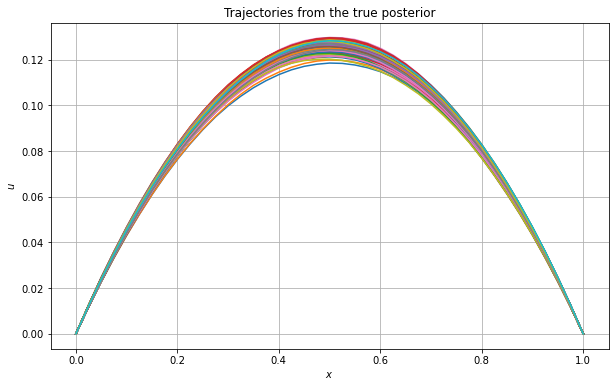

In [ ]:
#hide_input
plt.rcParams['figure.figsize'] = (10,6)
plt.plot(grid,u_sim)
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.title('Trajectories from the true posterior')
plt.grid()
plt.show()

In [ ]:
max_true = u_sim.max(axis=0)

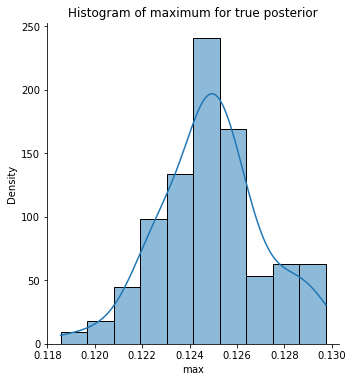

In [ ]:
#hide_input
sns.displot(max_true,kde=True,stat="density")
plt.xlabel('$\max$')
plt.title('Histogram of maximum for true posterior')
plt.show()

In [ ]:
def statFEM_posterior_sampler(n_sim, grid, h, f_bar, k_f, ϵ, Y, v_dat, par = False, trans = True, tol = 1e-9):
    # get length of grid
    d = len(grid)
    
    # get size of FE mesh
    J = int(np.round(1/h))
    
    # get statFEM posterior mean function
    m_post_fem = m_post_fem_assembler(J,f_bar,k_f,ϵ,Y,v_dat)
    μ_func = MyExpression()
    μ_func.f = m_post_fem
    
    # evaluate this on the grid
    μ = np.array([μ_func(x) for x in grid]).reshape(d,1)
    
    # get statFEM posterior cov mat on grid
    Σ = c_post_fem_assembler(J,k_f,grid,Y,ϵ,False,True)
    
    # construct the cholesky decomposition Σ = GG^T
    # we add a small diagonal perturbation to Σ to ensure it
    # strictly positive definite
    G = np.linalg.cholesky(Σ + tol * np.eye(d))

    # draw iid standard normal random vectors
    Z = np.random.normal(size=(d,n_sim))

    # construct samples from GP(m,k)
    Y = G@Z + np.tile(μ,n_sim)

    # return the sampled trajectories
    return Y

In [ ]:
%%time
h = 0.1
np.random.seed(3542)
u_sim_statFEM = statFEM_posterior_sampler(n_sim, grid, h, f_bar, k_f, ϵ, Y, v_dat)

CPU times: user 91.9 ms, sys: 16.8 ms, total: 109 ms
Wall time: 78 ms


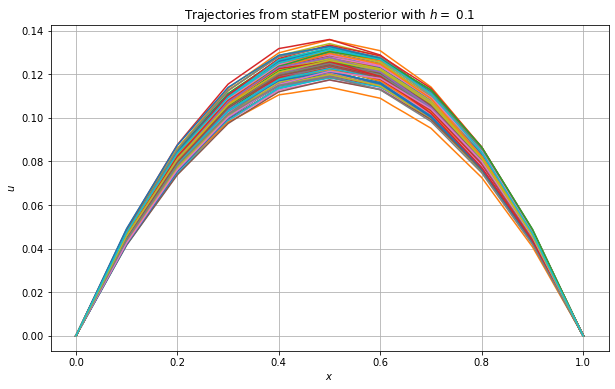

In [ ]:
#hide_input
plt.rcParams['figure.figsize'] = (10,6)
plt.plot(grid,u_sim_statFEM)
plt.grid()
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.title('Trajectories from statFEM posterior with $h = $ %0.1f' % h)
plt.show()

In [ ]:
max_statFEM = u_sim_statFEM.max(axis=0)

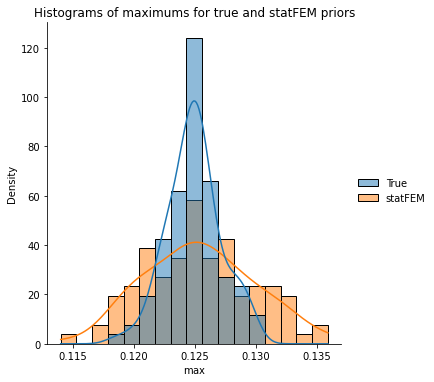

In [ ]:
#hide_input
max_data = pd.DataFrame(data={'True': max_true, 'statFEM': max_statFEM})
sns.displot(max_data,kde=True,stat="density")
plt.xlabel('$\max$')
plt.title('Histograms of maximums for true and statFEM priors')
plt.show()

In [ ]:
n_bins = np.arange(10,200,10)
wass_bin_dat = [wass(max_true,max_statFEM,n) for n in n_bins]

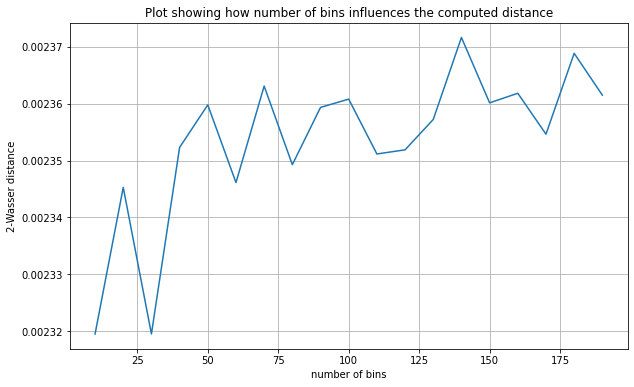

In [ ]:
#hide_input
plt.plot(n_bins,wass_bin_dat)
plt.grid()
plt.xlabel('number of bins')
plt.ylabel('2-Wasser distance')
plt.title('Plot showing how number of bins influences the computed distance')
plt.show()

In [ ]:
# set up range of h values to use
h_range_tmp = np.linspace(0.25,0.02,100)
h_range = 1/np.unique(np.round(1/h_range_tmp))
np.round(h_range,2)

array([0.25, 0.2 , 0.17, 0.14, 0.12, 0.11, 0.1 , 0.09, 0.08, 0.08, 0.07,
       0.07, 0.06, 0.06, 0.06, 0.05, 0.05, 0.05, 0.05, 0.04, 0.04, 0.04,
       0.04, 0.03, 0.03, 0.03, 0.03, 0.02, 0.02, 0.02])

In [ ]:
%%time
errors = []
###################
n_bins = 150
##################
np.random.seed(3252)
for h in tqdm(h_range):
    # sample trajectories from statFEM prior for current h value
    sim = statFEM_posterior_sampler(n_sim, grid, h, f_bar, k_f, ϵ, Y, v_dat)
    # get max
    max_sim = sim.max(axis=0)
    # compute error
    error = wass(max_true,max_sim,n_bins)
    # append to errors
    errors.append(error)

  0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 5.31 s, sys: 11.7 s, total: 17 s
Wall time: 2.6 s


In [ ]:
#hide
errors = np.array(errors)

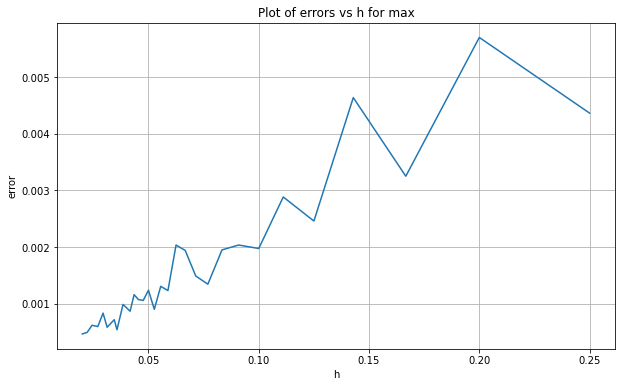

In [ ]:
#hide_input
plt.plot(h_range,errors)
plt.grid()
plt.xlabel('$h$')
plt.ylabel('error')
plt.title('Plot of errors vs $h$ for $\max$')
plt.show()

slope: 1.000882    intercept: -3.786228    r value: 0.961973     p value: 0.000000


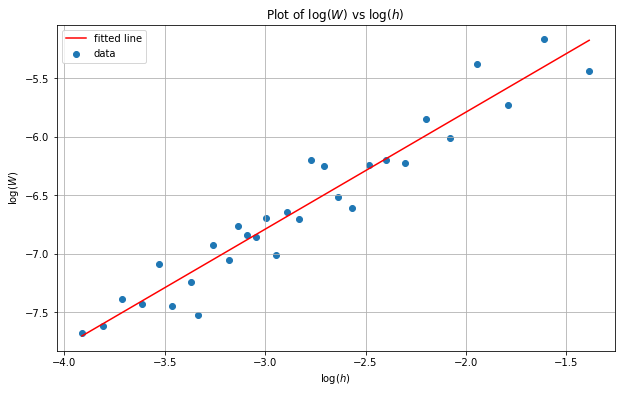

In [ ]:
#hide_input
log_h_range = np.log(h_range)
log_errors = np.log(errors)

# perform linear regression to get line of best fit for the log scales:
lm = linregress(log_h_range,log_errors)
print("slope: %f    intercept: %f    r value: %f     p value: %f" % (lm.slope, lm.intercept, lm.rvalue, lm.pvalue))

# plot line of best fit with the data:
x = np.linspace(np.min(log_h_range),np.max(log_h_range),100)
plt.scatter(log_h_range,log_errors,label='data')
plt.plot(x,lm.intercept + lm.slope * x, 'r', label='fitted line')
#plt.plot(x,-1+2*x,'--',c='black',label='reference line')
plt.grid()
plt.legend()
plt.xlabel('$\log(h)$')
plt.ylabel('$\log(W)$')
plt.title('Plot of $\log(W)$ vs $\log(h)$')
plt.savefig('1D_prior_results.png',dpi=300,bbox_inches='tight',facecolor="w")
plt.show()

In [ ]:
ϵ_list = [0.01,0.1,0.2,0.5,1.0]
results = {}

In [ ]:
%%time
np.random.seed(42)
tol = 1e-10
n_sim = 100
for ϵ in tqdm(ϵ_list,desc='Eps loop'):
    # generate sensor data
    v_dat = gen_sensor(ϵ,m_f,k_f,Y,u_quad,grid,maxiter=400)
    # get true B mat required for posterior
    B_true = (ϵ**2)*np.eye(s) + C_true_s

    # set up true posterior mean
    def true_mean(x):
        return m_post(x,μ_true,c_u_vect,v_dat,Y,B_true)
    
    # set up true posterior covariance
    def c_post_true(x,y):
        return c_post(x,y,c_u,Y,B_true)
    
    u_sim = sample_gp(n_sim, true_mean, c_post_true, grid,True,False)
    
    max_true = u_sim.max(axis=0)
    
    errors = []
    
    for h in tqdm(h_range):
        # sample trajectories from statFEM prior for current h value
        sim = statFEM_posterior_sampler(n_sim, grid, h, f_bar, k_f, ϵ, Y, v_dat)
        # get max
        max_sim = sim.max(axis=0)
        # compute error
        error = wass(max_true,max_sim,n_bins)
        # append to errors
        errors.append(error)
        
    results[ϵ] = errors

Eps loop:   0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

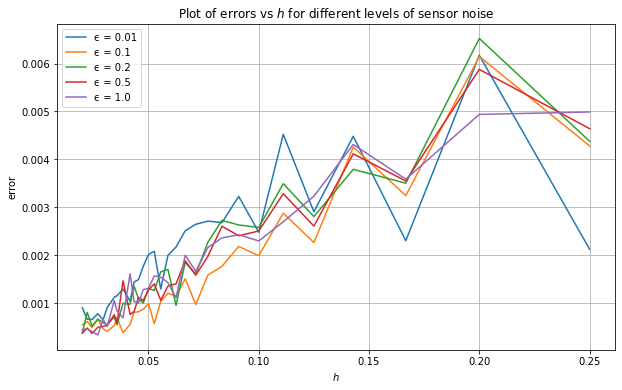

In [ ]:
#hide_input
plt.plot()
plt.grid()
plt.xlabel('$h$')
plt.ylabel('error')
plt.title('Plot of errors vs $h$ for different levels of sensor noise')
for ϵ in ϵ_list:
    errors = results[ϵ]
    plt.plot(h_range,errors, label = 'ϵ = ' + str(ϵ))
plt.legend()
plt.show()

ϵ: 0.01,    slope: 0.7804,    intercept: -4.1360
ϵ: 0.10,    slope: 1.0840,    intercept: -3.7181
ϵ: 0.20,    slope: 1.0539,    intercept: -3.5671
ϵ: 0.50,    slope: 1.1357,    intercept: -3.4046
ϵ: 1.00,    slope: 1.0904,    intercept: -3.4867


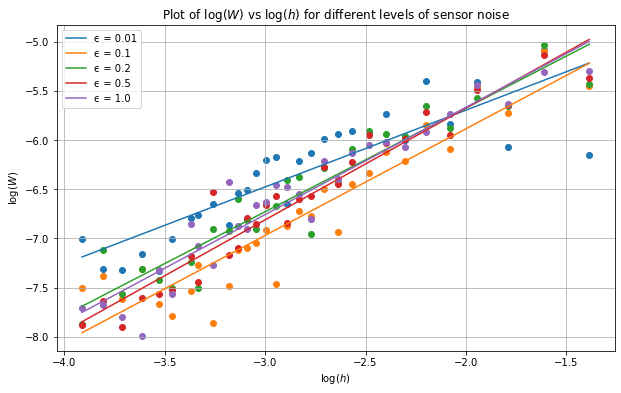

In [ ]:
#hide_input
plt.plot()
plt.grid()
plt.xlabel('$\log(h)$')
plt.ylabel('$\log(W)$')
plt.title('Plot of $\log(W)$ vs $\log(h)$ for different levels of sensor noise')
log_h_range = np.log(h_range)
for ϵ in ϵ_list:
    errors = results[ϵ]
    log_errors = np.log(errors)
    lm = linregress(log_h_range,log_errors)
    print('ϵ: %.2f,    slope: %.4f,    intercept: %.4f' % (ϵ, lm.slope,lm.intercept))
    plt.scatter(log_h_range,log_errors)
    plt.plot(x,lm.intercept + lm.slope * x, label='ϵ = ' +str(ϵ))
plt.legend()
plt.show()